### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot pre-fit results

env:HWW


### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
MODE = "slimmedtree"
# year = "2016"
# year = "2017"
# year = "2018"
year = "Full-Run2"
if MODE == "slimmedtree_validation":
    CustNanoData = {
        'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
        'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),          
        'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
        'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/ttbar_validation_final/Slimmed_Rest_ST.root"%(year),
        'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
        'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
        'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
        'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
        'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
        'ttbar_val'   : "/data/bond/zhaoyz/SlimmedTree/V5/%s/ttbar_validation_final/Slimmed_ttbar_validation.root"%(year),
    }
elif MODE == "tree_validation":
        CustNanoData = {
        'data'        : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Data/Tree_Data.root"%(year),
        'QCD'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/MC/Tree_QCD.root"%(year),          
        'WJets'       : "/data/bond/zhaoyz/Tree/V8/%s/Merged/MC/Tree_WJets.root"%(year),
        'Rest'        : "/data/bond/zhaoyz/Tree/V8/%s/Merged/ttbar_validation_final/Rest_ST.root"%(year),
        'TotalSignal' : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_Total.root"%(year),
        'ggF'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_GluGlu.root"%(year),
        'VH'          : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_VH.root"%(year),
        'ttH'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_ttH.root"%(year),
        'VBF'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_VBF.root"%(year),
        'ttbar_val'   : "/data/bond/zhaoyz/Tree/V8/%s/Merged/ttbar_validation_final/ttbar_validation.root"%(year),
    }
else:
    CustNanoData = {
        'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Data/SlimmedTree_Data.root",
        'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_QCD.root",          
        'Top'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Top.root",
        'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_WJets.root",
        'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Rest.root",
        'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_Total.root",
        'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_GluGlu.root",
        'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VH.root",   
        'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_ttH.root",
        'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VBF.root",
    }    
BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })


#for deco
files[r"$H^{4q}$"] = files["TotalSignal"][files["TotalSignal"]["R4q_a"] == 1]
files[r"$H^{3q}$"] = files["TotalSignal"][(files["TotalSignal"]["R3q_a"] == 1) & (files["TotalSignal"]["R3q_taudecay_a"] != 1)]
files["W"] = files["TotalSignal"][files["TotalSignal"]["w_a"] == 1]
files["top"] = files["TotalSignal"][files["TotalSignal"]["t_a"] == 1]
files["Z"] = files["TotalSignal"][files["TotalSignal"]["z_a"] == 1]
files[r"$H^{lqq}$"] = files["TotalSignal"][(files["TotalSignal"]["Rlqq_a"] == 1) | (files["TotalSignal"]["R3q_taudecay_a"] == 1)]
files["g/q"] = files["TotalSignal"][files["TotalSignal"]["gKK_g_a"] == 1]
files["rest"] = files["TotalSignal"][(files["TotalSignal"]["u_a"] == 1) | (files["TotalSignal"]["Rlq_a"] == 1) | (files["TotalSignal"]["R2q_a"] == 1)]


### Get DPhi in the events

In [3]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data


[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82, 2.01, 2.45]
Add d

In [4]:

def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)),mH_reco, events["Mj_V2_a"])


In [5]:
for k in files:
    print("Add reco of:",k)
    get_reco(events=files[k])

Add reco of: data


Add reco of: QCD
Add reco of: Top
Add reco of: WJets
Add reco of: Rest
Add reco of: TotalSignal
Add reco of: ggF
Add reco of: VH
Add reco of: ttH
Add reco of: VBF
Add reco of: $H^{4q}$
Add reco of: $H^{3q}$
Add reco of: W
Add reco of: top
Add reco of: Z
Add reco of: $H^{lqq}$
Add reco of: g/q
Add reco of: rest


### some test about variables

In [6]:
files["VBF"]["DPhi"]

<Array [2.97, 2.31, 0.0849, ... 2.01, 2.45] type='17017 * float32'>

### plot setting

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### prepare prefit QCD distribution for CR and SR respectively

In [10]:
def store_root(file_name, dir_name, hist_name, bin_edges, bin_contents, bin_errors, rewrite = False, verbose = False):
    if os.path.exists(file_name):
        if verbose: print(f"The file '{file_name}' already exists.")
        if not rewrite:
            if verbose:print("Will update it.")
            output_file = ROOT.TFile(file_name, "update")
        else: 
            if verbose:print("Will recreate one.")
            output_file = ROOT.TFile(file_name, "recreate")
    else:
        if verbose:print(f"The file '{file_name}' does not exist, will create a new one")
        output_file = ROOT.TFile(file_name, "recreate")
    if output_file.GetDirectory(dir_name):
        if verbose:print("The " + dir_name + " directory exists in the ROOT file, use the existing one")
        output_file.cd(dir_name)
    else:
        if verbose:print("The " + dir_name + " directory does not exist in the ROOT file, create a new one")
        output_file.mkdir(dir_name)
        output_file.cd(dir_name)
    histogram = ROOT.TH1D(hist_name, "Histogram 1", len(bin_edges) - 1, bin_edges)
    for i, content in enumerate(bin_contents):
        histogram.SetBinContent(i + 1, content)
        histogram.SetBinError(i + 1, bin_errors[i]) 
    histogram.Write()
    output_file.Close()
    

    # Return the updated histogram and variance

#Function that plot mass distribution, with different tagger cut in the same plot.
def plot_mass_shape_store_blinded(files, nbins=20, x_min=40, x_max=240, legend_location='upper left',suffix = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year="Full-Run2", ax=ax, fontname='sans-serif')
    def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
        h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
        if overflow: 
            # h, var also include underflow bins but in plots usually no underflow data
            # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
            # You have to access the overflow and underflow bins data like below:
            h[-2] += h[-1]; var[-2] += var[-1]
        if underflow:
            h[1] += h[0]; var[1] += var[0]
        if overflow or underflow:
            h, var = h[1:-1], var[1:-1]
        return np.array([h, var])
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        else: print("invalid SR value")
        return maskdict_sr
    def maskdict_cr(files_i, CR):
        events = files_i
        if   CR == "SR1a" or CR == "SR1b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] < 0.92)), 
        elif CR == "SR2a" or CR == "SR2b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] < 0.92) & (events["DPhi"] < 0.8)),         
        else: print("invalid CR value")
        return maskdict_cr
    for met in ["SR1","SR2"]:
        #we store just 1 root files 
        rest = ["Top","WJets","Rest"]
        events_rest_tmp = ak.concatenate([files[i] for i in rest], axis=0)
        hist_cr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Data = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Rest = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        events_cr_QCD     = files["QCD"][maskdict_cr(files["QCD"],met + "a")]
        events_cr_Data    = files["data"][maskdict_cr(files["data"],met + "a")]
        events_cr_Rest    = events_rest_tmp[maskdict_cr(events_rest_tmp,met + "a")]
        hist_cr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #only used to calculate CR QCD yields
        hist_cr_Data.fill(events_cr_Data["MH_Reco"],  weight = events_cr_Data["weight"])
        hist_cr_Rest.fill(events_cr_Rest["MH_Reco"],  weight = events_cr_Rest["weight"])
        bins = hist_cr_QCD.axes[0].edges
        yields_cr_QCD = np.sum(flow(hist_cr_QCD)[0]) # to include overflow
        # hist_cr_QCD_value    = flow(hist_cr_QCD)[0] # not used at all 
        hist_cr_Data_value   = flow(hist_cr_Data)[0]
        hist_cr_Rest_value   = flow(hist_cr_Rest)[0] 
        # hist_err_cr_QCD_value    = np.sqrt(flow(hist_cr_QCD)[1]) #not used at all
        hist_err_cr_Data_value   = np.sqrt(flow(hist_cr_Data)[1])
        hist_err_cr_Rest_value   = np.sqrt(flow(hist_cr_Rest)[1])
        # print("hist value and variance done.")                          
        hist_Data_Rest_value = hist_cr_Data_value - hist_cr_Rest_value
        hist_err_Data_Rest_value = np.sqrt((hist_err_cr_Data_value)**2 + (hist_err_cr_Rest_value)**2 )  
        hep.histplot(hist_Data_Rest_value,     bins=bins, yerr=hist_err_Data_Rest_value, label= met.replace("S","C") + " estimated QCD(pre-fit)", lw = 2,edges = True, histtype="step") #,color = "red")
        if met == "SR1" : store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=True)
        else: store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=False)              
        print("finish ", met.replace("S","C"))
        for region in ["a","b"]:
            hist_sr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
            events_cr_QCD     = files["QCD"][maskdict_sr(files["QCD"],met+region)]
            hist_sr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #also only used for SR QCD yields
            yields_sr_QCD = np.sum(flow(hist_sr_QCD)[0]) 
            mc_ratio = yields_sr_QCD/yields_cr_QCD
            hist_value = mc_ratio * hist_Data_Rest_value #means hist value in SR, using mc_ratio * hist_Data_Rest_value in CR QCD
            hist_err_value = mc_ratio * hist_err_Data_Rest_value
            hep.histplot(hist_value,     bins=bins, yerr=hist_err_value, label= met + region + " estimated QCD(pre-ft)", lw = 2,edges = True, histtype="step") #,color = "red")      
            store_root("./root/perfit_QCD.root","QCD",met+ region ,bin_edges = bins, bin_contents = hist_value, bin_errors = hist_err_value, rewrite=False)
            print("finish ",met + region)              
    # plt.ylim(0, 1e9)
    plt.xlabel("Higgs candidate MET-reco. mass", fontsize=20, ha='right', x=1)
    plt.ylabel("Events.", fontsize=20, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1, top = 1e9)
    path_str = "./plots/prefit/"
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    plt.legend(loc=legend_location,frameon=False,fontsize=12)
    plt.savefig(path_str + f"prefitmass_distri_prefit_QCD_{suffix}.pdf", bbox_inches='tight')
    plt.show()

finish  CR1
finish  SR1a
finish  SR1b
finish  CR2
finish  SR2a
finish  SR2b


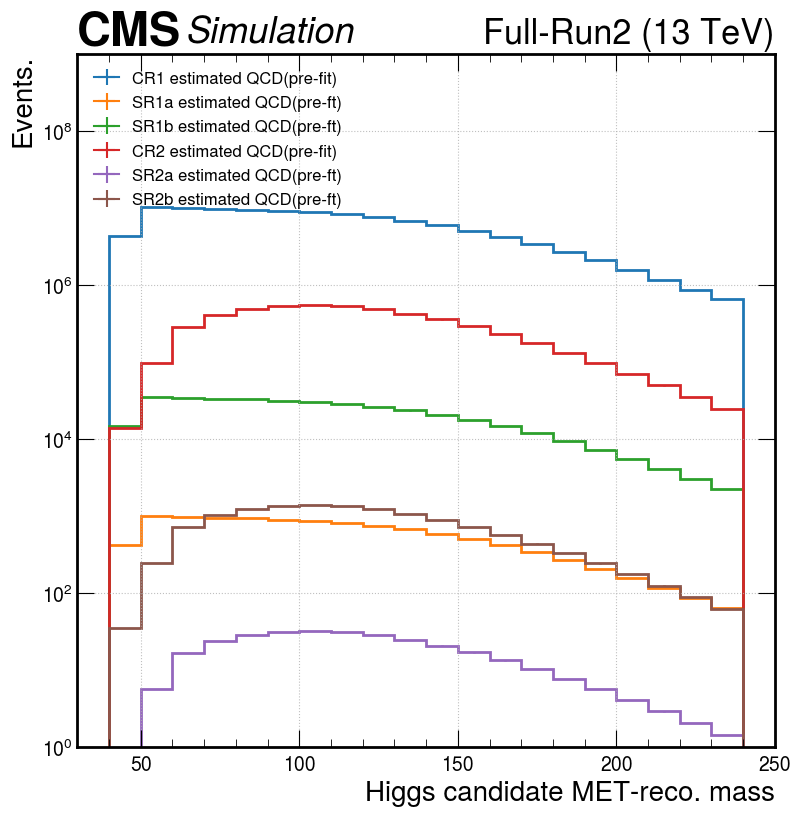

In [11]:
plot_mass_shape_store_blinded(files = files,nbins = 20, x_min=40, x_max=240,suffix = "")

### read the files just stored

In [12]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### Plot variables

In [26]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def prefit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",optimal_cut = True, deco = False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 90, arrays["data"] >= 150)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":   
                # read from root:  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
                # no root is used here:
                # stacked['h'][k] = h
                # stacked['var'][k] = var
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    SIG_DECO_COLOR = {'TotalSignal': 'black',r"$H^{4q}$":"green",r"$H^{3q}$":"orange","W":"blue","top":"purple","Z":"yellow",r"$H^{lqq}$":"cyan","g/q":"pink","rest":"gray"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            if deco != True:
                if k in ["TotalSignal","ggF","VH","ttH","VBF"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            else: #deco mode
                # suffix += "DECO"
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = './plots/prefit/23Jan2024'
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [23]:
CUT = {        
    "SR1a" : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.99) for k in files}, 
    "SR1b" : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) for k in files},   
    "SR2a" : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.99) & (files[k]["DPhi"] < 0.8)for k in files}, 
    "SR2b" : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) & (files[k]["DPhi"] < 0.8)for k in files},   
    "CR1"  : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] < 0.92) for k in files},
    "CR2"  : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)  & (files[k]["a_HWW_V2"] < 0.92) & (files[k]["DPhi"] < 0.8) for k in files},   
    }

# CR: < 0.92

In [ ]:
CUT_BLINDED = {
        "SR1a_blinded" : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.99) for k in files}, 
        "SR1b_blinded" : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) for k in files},   
        "SR2a_blinded" : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.99) & (files[k]["DPhi"] < 0.8)for k in files}, 
        "SR2b_blinded" : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) & (files[k]["DPhi"] < 0.8)for k in files},   
        "CR1_blinded"  : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] < 0.92) for k in files},
        "CR2_blinded"  : {k: ((files[k]["MH_Reco"] <= 90) | (files[k]["MH_Reco"] >= 150)) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)  & (files[k]["a_HWW_V2"] < 0.92) & (files[k]["DPhi"] < 0.8)for k in files},   
}

In [24]:
def prefit_runPlots(region = "PS", events = files,nametext = "", blind = False, othertext = ""):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=r'$jet_{a}:MET-recovery\, Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False,deco = True)

Should scale signal *  311.989411344647
Optimal two-side cut = 4 12 0.4055131342625679
Optimal one-side cut = 4 0.3845086373121161
Optimal mid-side cut =  3 0.23795352304817205


/tmp/ipykernel_20125/748093752.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: Runt

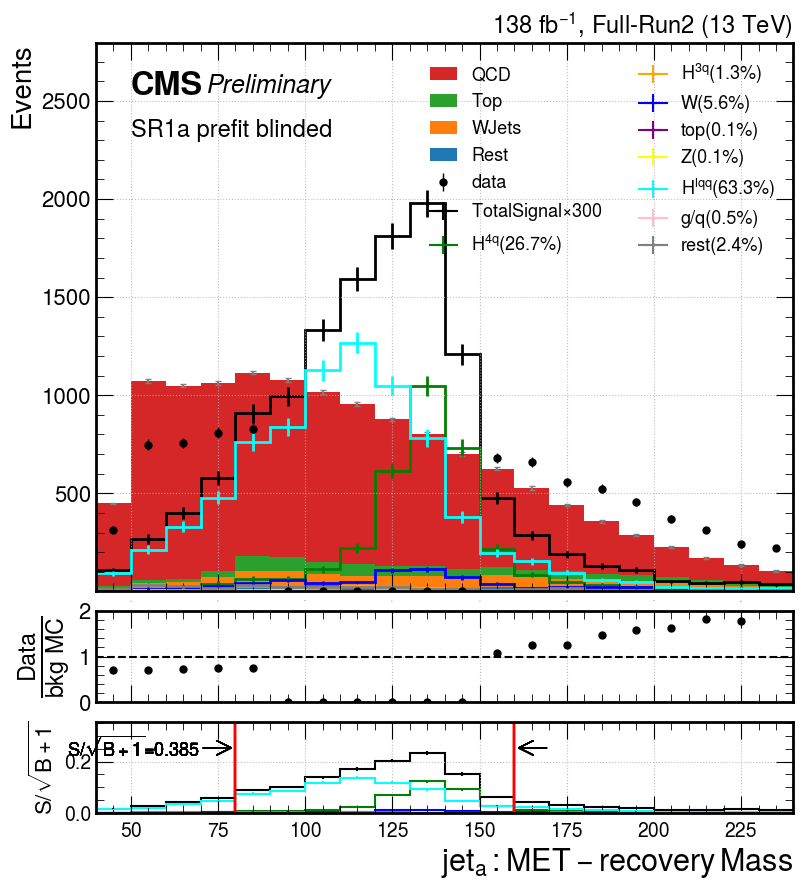

Should scale signal *  2836.324639054116
Optimal two-side cut = 7 12 0.26652987167023684
Optimal one-side cut = 6 0.2532975426951379
Optimal mid-side cut =  13 0.13063763555006583


/tmp/ipykernel_20125/748093752.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


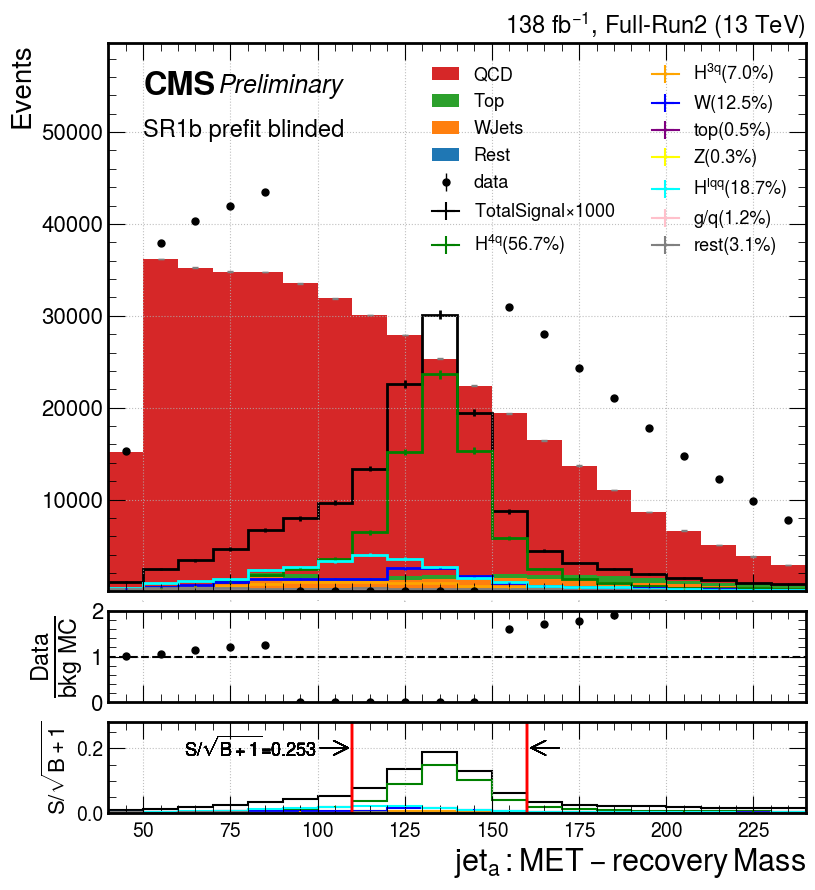

Should scale signal *  126921.25892197387
Optimal two-side cut = 3 20 0.08620324401110788
Optimal one-side cut = 3 0.08620324448562473
Optimal mid-side cut =  19 0.026296696032519357


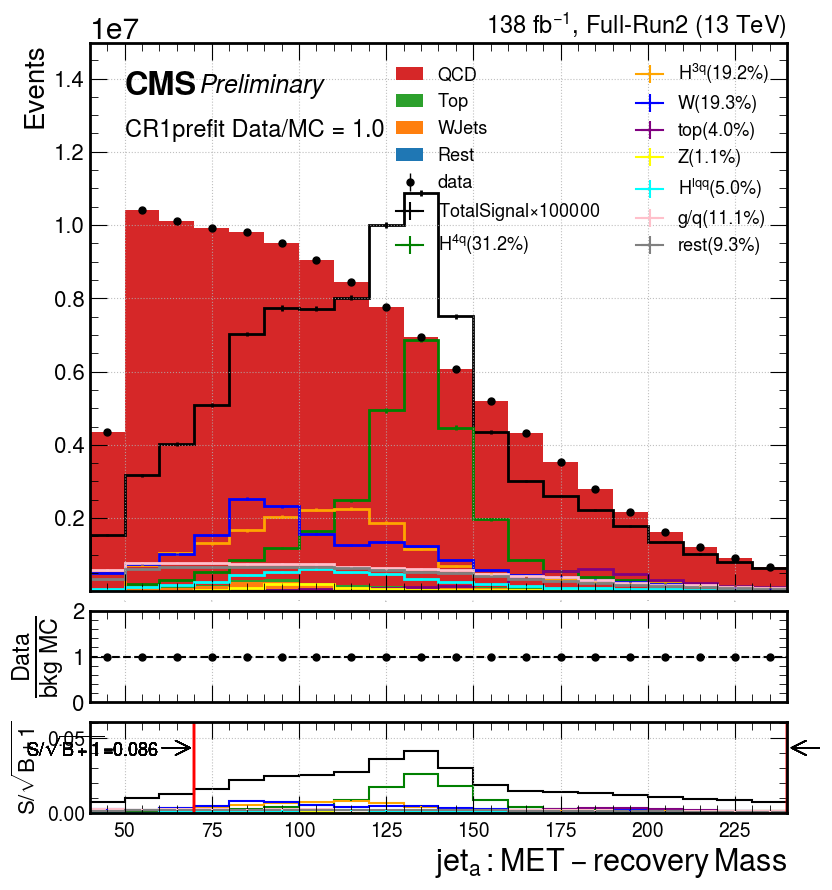

/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/748093752.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: Runt

Should scale signal *  43.96255382412356
Optimal two-side cut = 3 11 0.7308438099684478
Optimal one-side cut = 1 0.6615890072656949
Optimal mid-side cut =  2 0.6156680891773536


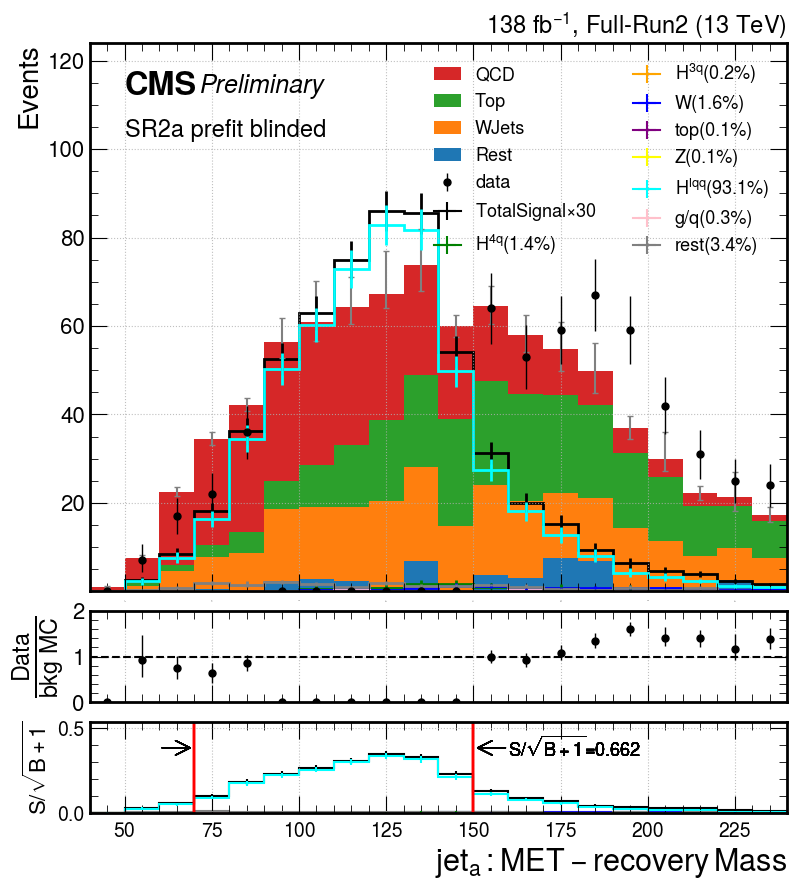

Should scale signal *  536.9461625385552
Optimal two-side cut = 3 20 0.23873847229380296
Optimal one-side cut = 3 0.23874620533237212
Optimal mid-side cut =  4 0.181634085261769


/tmp/ipykernel_20125/748093752.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: Runt

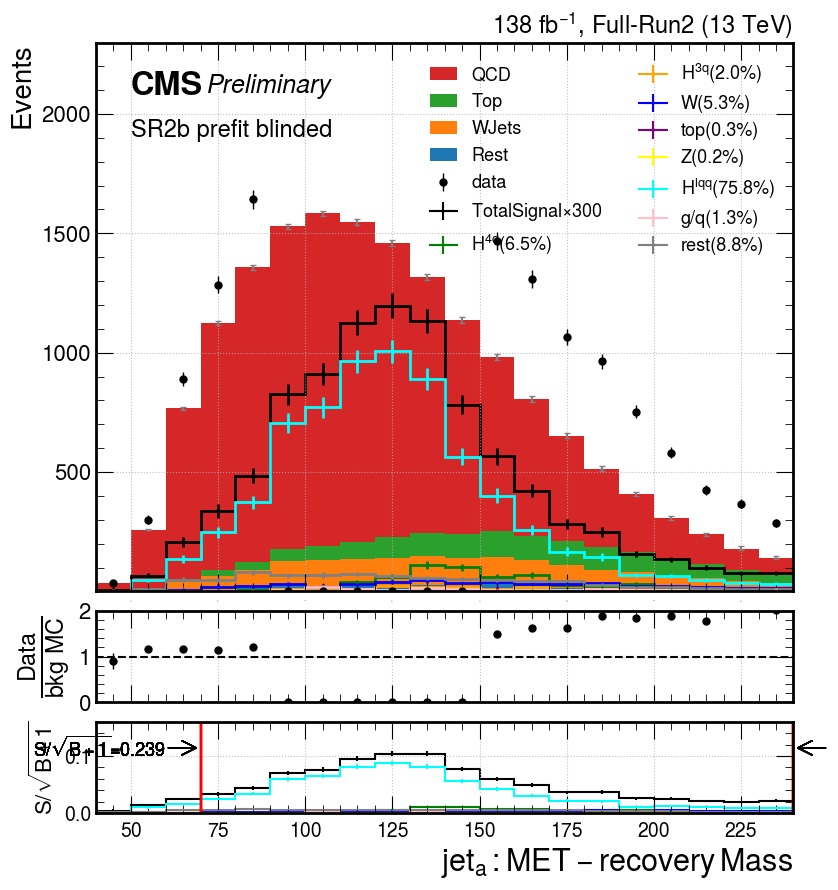

Should scale signal *  41681.27091670321
Optimal two-side cut = 3 20 0.05648588993928088
Optimal one-side cut = 3 0.05648589542716124
Optimal mid-side cut =  4 0.020209467870293246


/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_20125/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_20125/314159992.py:52: RuntimeWarning: invalid value encountered in divide


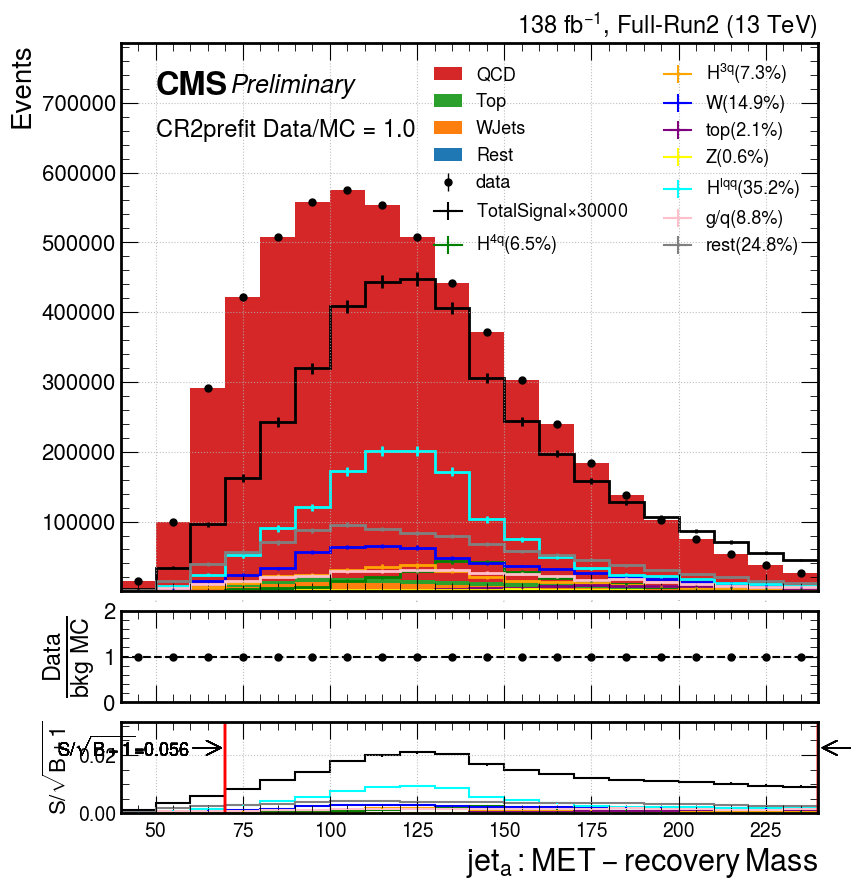

In [27]:
prefit_runPlots(region = "SR1a", blind = True, othertext = "prefit")
prefit_runPlots(region = "SR1b", blind = True, othertext = "prefit")
prefit_runPlots(region = "CR1",  blind = False, othertext = "prefit")
prefit_runPlots(region = "SR2a", blind = True, othertext = "prefit")
prefit_runPlots(region = "SR2b", blind = True, othertext = "prefit")
prefit_runPlots(region = "CR2",  blind = False, othertext = "prefit")

### Define observable object variables

In [8]:
@dataclass
class ShapeVar:
    """Class to store attributes of a variable to make a histogram of.

    Args:
        var (str): variable name
        label (str): variable label
        bins (List[int]): bins
        reg (bool, optional): Use a regular axis or variable binning. Defaults to True.
        blind_window (List[int], optional): if blinding, set min and max values to set 0. Defaults to None.
        significance_dir (str, optional): if plotting significance, which direction to plot it in.
          See more in plotting.py:ratioHistPlot(). Options are ["left", "right", "bin"]. Defaults to "right".
    """

    var: str = None
    label: str = None
    bins: List[int] = None
    reg: bool = True #regular axis
    blind_window: List[int] = None
    significance_dir: str = "right"

    def __post_init__(self):
        # create axis used for histogramming
        if self.reg:
            self.axis = hist2.axis.Regular(*self.bins, name=self.var, label=self.label)
        else:
            self.axis = hist2.axis.Variable(self.bins, name=self.var, label=self.label)
def blindBins(h: hist2.Hist, blind_region: List, blind_sample: str = None, axis=0):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_sample`` specified, only blind that sample, else blinds all.
    """
    if axis > 0:
        raise Exception("not implemented > 1D blinding yet")

    bins = h.axes[axis + 1].edges
    lv = int(np.searchsorted(bins, blind_region[0], "right"))
    rv = int(np.searchsorted(bins, blind_region[1], "left") + 1)

    if blind_sample is not None:
        data_key_index = np.where(np.array(list(h.axes[0])) == blind_sample)[0][0]
        h.view(flow=True)[data_key_index][lv:rv].value = 0
        h.view(flow=True)[data_key_index][lv:rv].variance = 0
    else:
        h.view(flow=True)[:, lv:rv].value = 0
        h.view(flow=True)[:, lv:rv].variance = 0       
shape_vars = [
    ShapeVar(
        "MH_Reco",
        r"Higgs candidate MET recovery mass [GeV]",
        [20, 40, 240],
        reg=True,
        blind_window=[80, 160],
    )
]


### Save hist templates to pkl files

In [26]:

def save_pkl(files, template_file = "./templates/hists_templates_run2.pkl"):
    regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2","SR3a","SR3b","CR3"] #signal regions or control regions
    # regions = ["SR1a","SR1b","CR1a","CR1b","SR2a","SR2b","CR2a","CR2b","SR3a","SR3b","CR3a","CR3b"]
    # samples = list(['data','QCD','Top','WJets','Rest','TotalSignal','ggF','VH','ttH','VBF']) 
    samples = list(['data','QCD','Top','WJets','Rest','ggF','VH','ttH','VBF']) # ignore the combined "TotalSignal" for a test
    weights = [] #uncertainties to be added 
    templates = {}
    for region in regions:
        templates[region] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            # hist2.axis.StrCategory([], name="systematic", growth=True),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        for sample in samples:
            data = files[sample][CUT[region][sample]] if ("blinded" not in region) else files[sample][CUT_BLINDED[region][sample]]
            templates[region].fill(
                Sample=sample,
                # systematic="nominal",
                MH_Reco=data["MH_Reco"],
                weight=data["weight"],
            )
            if sample == "data": 
                if (region.endswith("a") or region.endswith("b")):
                    # blind signal mass windows in pass region in data
                    print("blind data of ",region)
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[region], shape_var.blind_window, "data", axis=i) 
            for weight in weights:
                pass #uncertainties to be added
        print("done fill template ",region)        
    #Creates blinded copies of each region's templates and saves a pickle of the templates
    blind_window = shape_vars[0].blind_window
    for label, template in list(templates.items()):
        blinded_template = deepcopy(template)
        blindBins(blinded_template, blind_window)
        templates[f"{label}Blinded"] = blinded_template
    with open(template_file, "wb") as fp:
        pkl.dump(templates, fp) # dump the templates of each region in a pkl file
        print("Saved templates to", template_file)

In [8]:
save_pkl(files = files)


blind data of  SR1a
done fill template  SR1a
blind data of  SR1b
done fill template  SR1b
done fill template  CR1
blind data of  SR2a
done fill template  SR2a
blind data of  SR2b
done fill template  SR2b
done fill template  CR2
blind data of  SR3a
done fill template  SR3a
blind data of  SR3b
done fill template  SR3b
done fill template  CR3
Saved templates to ./templates/hists_templates_run2_newCR.pkl


### some test about the output templates

In [27]:
with open("/home/pku/zhaoyz/Higgs/boostedHWW/combine/templates/hists_templates_run2.pkl","rb") as f:
    hists_template = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
hists_template["pass"]["QCD",:]

Hist(Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=39.3871, variance=137.026)

In [36]:
with open("/home/pku/zhaoyz/Higgs/HHbbVV/src/HHbbVV/postprocessing/templates/23Jun14/2018_templates.pkl","rb") as f:
    hists_template1 = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
# hists_template["CR2"]["QCD",:]
# hists_template["CR1"]["QCD",:]
# hists_template.

In [37]:
hists_template1.keys()

dict_keys(['pass', 'fail', 'pass_JES_up', 'fail_JES_up', 'pass_JES_down', 'fail_JES_down', 'pass_JER_up', 'fail_JER_up', 'pass_JER_down', 'fail_JER_down', 'pass_JMS_up', 'fail_JMS_up', 'pass_JMS_down', 'fail_JMS_down', 'pass_JMR_up', 'fail_JMR_up', 'pass_JMR_down', 'fail_JMR_down', 'passBlinded', 'failBlinded', 'pass_JES_upBlinded', 'fail_JES_upBlinded', 'pass_JES_downBlinded', 'fail_JES_downBlinded', 'pass_JER_upBlinded', 'fail_JER_upBlinded', 'pass_JER_downBlinded', 'fail_JER_downBlinded', 'pass_JMS_upBlinded', 'fail_JMS_upBlinded', 'pass_JMS_downBlinded', 'fail_JMS_downBlinded', 'pass_JMR_upBlinded', 'fail_JMR_upBlinded', 'pass_JMR_downBlinded', 'fail_JMR_downBlinded'])

In [38]:
hists_template1["passBlinded"]

Hist(
  StrCategory(['HHbbVV', 'ggHH_kl_2p45_kt_1_HHbbVV', 'ggHH_kl_5_kt_1_HHbbVV', 'ggHH_kl_0_kt_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 'Data', 'HHbbVV_txbb_down', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_down', 'ggHH_kl_5_kt_1_HHbbVV_txbb_down', 'ggHH_kl_0_kt_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down', 'HHbbVV_pileup_down', 'ggHH_kl_2p45_kt_1_HHbbVV_pileup_down', 'ggHH_kl_5_kt_1_HHbbVV_pileup_down', 'ggHH_kl_0_kt_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileup_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_pileup_down', 'QCD_pileup_down', 'TT_pileup_down', 'ST_pileup_down', 'V+Jets_pileup_down', 'Diboson_pileup_down', 'HHbbVV_ISRPartonShower_down', 'ggHH_kl_2p45_kt_1_HHbbVV_ISRPartonShower_down', 'ggHH_kl_5_kt_1_HHbbVV_ISRPartonShower_down', 'ggHH_kl_0_kt_1_HHbbVV_ISRPartonShower_down', 'V+Jets_ISRPartonShower_down', 'HHbbVV_FSRPartonShower_down', 'ggHH_kl_2p45_kt_1_HHbbVV_FSRPartonShower_down', 'ggHH_kl_5_kt_1_HHbbVV_FSRPartonShower_down', 'ggHH_kl_0_kt_1_HHbbVV_FSRPartonShower_down', 'V+Jets_FSRPartonShower_down', 'HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_2p45_kt_1_HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_5_kt_1_HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_0_kt_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_down', 'QCD_L1EcalPrefiring_down', 'TT_L1EcalPrefiring_down', 'ST_L1EcalPrefiring_down', 'V+Jets_L1EcalPrefiring_down', 'Diboson_L1EcalPrefiring_down', 'HHbbVV_txbb_up', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_up', 'ggHH_kl_5_kt_1_HHbbVV_txbb_up', 'ggHH_kl_0_kt_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_up', 'HHbbVV_pileup_up', 'ggHH_kl_2p45_kt_1_HHbbVV_pileup_up', 'ggHH_kl_5_kt_1_HHbbVV_pileup_up', 'ggHH_kl_0_kt_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileup_up', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_pileup_up', 'QCD_pileup_up', 'TT_pileup_up', 'ST_pileup_up', 'V+Jets_pileup_up', 'Diboson_pileup_up', 'HHbbVV_ISRPartonShower_up', 'ggHH_kl_2p45_kt_1_HHbbVV_ISRPartonShower_up', 'ggHH_kl_5_kt_1_HHbbVV_ISRPartonShower_up', 'ggHH_kl_0_kt_1_HHbbVV_ISRPartonShower_up', 'V+Jets_ISRPartonShower_up', 'HHbbVV_FSRPartonShower_up', 'ggHH_kl_2p45_kt_1_HHbbVV_FSRPartonShower_up', 'ggHH_kl_5_kt_1_HHbbVV_FSRPartonShower_up', 'ggHH_kl_0_kt_1_HHbbVV_FSRPartonShower_up', 'V+Jets_FSRPartonShower_up', 'HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_2p45_kt_1_HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_5_kt_1_HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_0_kt_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1p5_C2

In [39]:
hists_template1["passBlinded"]["Data",:]

Hist(Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=30, variance=30)

In [40]:
with open("/home/pku/zhaoyz/Higgs/boostedHWW/combine/templates/hists_templates_run2.pkl","rb") as f:
    hists_template2 = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
# hists_template["CR2"]["QCD",:]
hists_template2["SR1aBlinded"]["data",:]

Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=33745, variance=33745) (WeightedSum(value=37202, variance=37202) with flow)

In [18]:
hists_template["passBlinded"]

Hist(
  StrCategory(['HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 'Data', 'HHbbVV_txbb_down', 'HHbbVV_pileup_down', 'QCD_pileup_down', 'TT_pileup_down', 'ST_pileup_down', 'V+Jets_pileup_down', 'Diboson_pileup_down', 'HHbbVV_PDFalphaS_down', 'HHbbVV_ISRPartonShower_down', 'V+Jets_ISRPartonShower_down', 'HHbbVV_FSRPartonShower_down', 'V+Jets_FSRPartonShower_down', 'HHbbVV_L1EcalPrefiring_down', 'QCD_L1EcalPrefiring_down', 'TT_L1EcalPrefiring_down', 'ST_L1EcalPrefiring_down', 'V+Jets_L1EcalPrefiring_down', 'Diboson_L1EcalPrefiring_down', 'HHbbVV_txbb_up', 'HHbbVV_pileup_up', 'QCD_pileup_up', 'TT_pileup_up', 'ST_pileup_up', 'V+Jets_pileup_up', 'Diboson_pileup_up', 'HHbbVV_PDFalphaS_up', 'HHbbVV_ISRPartonShower_up', 'V+Jets_ISRPartonShower_up', 'HHbbVV_FSRPartonShower_up', 'V+Jets_FSRPartonShower_up', 'HHbbVV_L1EcalPrefiring_up', 'QCD_L1EcalPrefiring_up', 'TT_L1EcalPrefiring_up', 'ST_L1EcalPrefiring_up', 'V+Jets_L1EcalPrefiring_up', 'Diboson_L1EcalPrefiring_up'], name='Sample'),
  Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=461.893, variance=1092.32)

In [19]:
sample_template = hists_template["pass"]["QCD", :]
err = sample_template.variances()
err

array([13.28524337,  1.63602478, 35.13665137, 24.8476674 , 17.38421633,
        0.23765398,  0.        ,  0.        ,  0.        , 14.19115751,
       12.12285395,  0.        ,  0.        , 18.0306419 ,  0.        ,
        0.        ,  0.        ,  0.15379214,  0.        ,  0.        ])

In [5]:
for i , axis in enumerate(hists_template["pass"].axes[1:]):
    print(i, axis)

0 Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)')


In [13]:
with open("./templates/hists_templates_non_blinded.pkl", "rb") as f:
    hists_templates3 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
# hists_templates3["SR2a"]["WJets",:].variances()
# hists_templates3["SR2a"]["WJets",:].values(flow=True)
# hists[region][sample,:].variances()
# hists_templates3["SR3a"]["QCD",:].sum().value
# hists_templates3["SR3a_blinded"].axes[1:].edges
hists_templates3["SR1a"]["data",:]


Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=33745, variance=33745) (WeightedSum(value=37202, variance=37202) with flow)

In [18]:
def get_template(h, sample):
    ''' 
    histogram h Hist, with axes:["samples","systematic","MH_Reco"]
    sample is sample name in ["QCD",...,"data"]
    '''
    mass_axis = 1 #axis index
    massbins = h.axes[mass_axis].edges
    return (h[sample, :].values(), massbins, "MH_Reco")
a = get_template(hists_templates3["SR3a"],"QCD")
a

(array([ 0.        ,  2.61734887,  2.40244829, 13.38662184,  0.        ,
        12.94938391,  7.15780488, 11.0105996 , 18.07070539,  0.        ,
         7.82469779,  0.89133593,  1.93871653,  2.80038463,  3.449436  ,
         0.53863144,  0.2711149 ,  0.3287236 ,  0.        ,  2.0529086 ]),
 array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
        150., 160., 170., 180., 190., 200., 210., 220., 230., 240.]),
 'MH_Reco')

In [11]:
print(np.linspace(40, 240, 21))

[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]


In [22]:
region = "SR1a_blinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a_blinded'

In [23]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/templates/hists_templates.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2["SR1a"]


Hist(
  StrCategory(['data', 'QCD', 'Top', 'WJets', 'Rest', 'TotalSignal', 'ggF', 'VH', 'ttH', 'VBF'], growth=True, name='samples'),
  StrCategory(['nominal'], growth=True, name='systematic'),
  Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'),
  storage=Double()) # Sum: 180718.16633693522 (187720.00093823727 with flow)

In [24]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
s

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [25]:
s = hists_templates2["SR2b"]["WJets","nominal",:].variances()
s

In [26]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
values_nominal = np.maximum(s, 0.0)
values_nominal

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [28]:
# values_nominal = np.maximum(s.values(), 0.0)
# values_nominal

In [29]:
for i, axis in enumerate(hists_templates2["SR1a"].axes[2:]):
    print(i, axis) 

0 Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]')


In [ ]:
region = "SR1a"
region2 = "CR1"
pass_region = (region.endswith("a") or region.endswith("b"))
pass_region

True

In [ ]:
hists_templates["SR3a"].project("MH_Reco") #N.B. here data is also added

Hist(Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Double()) # Sum: 1284.0328060902589 (1391.2353290328374 with flow)

In [ ]:
hists_templates["SR3a"].axes[2].edges #access the axes through index

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
       150., 160., 170., 180., 190., 200., 210., 220., 230., 240.])

In [ ]:
massbins = hists_templates["SR1a"].axes[2].edges
masses = (massbins[:-1] + 0.5 * np.diff(massbins))
mass_scaled = (masses - masses[0]) / (masses[-1] - masses[0])
mass_scaled

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [ ]:
hists_templates["SR3a"][{"samples": "QCD", "systematic": "nominal"}].values() #another way to access the value

array([ 0.        ,  1.85686087,  5.33073188, 11.09815239, 13.09203295,
       13.29814235, 14.8429755 , 14.00588169, 12.18572567, 10.69694686,
        9.2954443 ,  7.19961509,  6.13408838,  4.63281281,  4.22245801,
        2.41129675,  1.95302421,  1.59153709,  0.65292898,  2.98913682])

In [ ]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedhiggs/combine/templates/v1/hists_templates_2017_ele.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2

{'pass': Hist(
   StrCategory(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'ggF', 'WZQQ', 'Data', 'QCD', 'Diboson', 'ttH'], growth=True, name='samples'),
   StrCategory(['nominal', 'weight_ele_pileupUp', 'weight_ele_pileupDown', 'weight_ele_isolation_electronUp', 'weight_ele_isolation_electronDown', 'weight_ele_id_electronUp', 'weight_ele_id_electronDown', 'weight_ele_L1PrefiringUp', 'weight_ele_L1PrefiringDown', 'weight_ele_trigger_electronUp', 'weight_ele_trigger_electronDown', 'weight_ele_reco_electronUp', 'weight_ele_reco_electronDown', 'weight_ele_aS_weightUp', 'weight_ele_aS_weightDown', 'weight_ele_UEPS_FSRUp', 'weight_ele_UEPS_FSRDown', 'weight_ele_UEPS_ISRUp', 'weight_ele_UEPS_ISRDown', 'weight_ele_PDF_weightUp', 'weight_ele_PDF_weightDown', 'weight_ele_PDFaS_weightUp', 'weight_ele_PDFaS_weightDown', 'weight_ele_scalevar_3ptUp', 'weight_ele_scalevar_3ptDown', 'weight_ele_scalevar_7ptUp', 'weight_ele_scalevar_7ptDown', 'weight_ele_d1K_NLOUp', 'weight_ele_d1K_NLODow

In [ ]:
regions = {
        "CR1" :{"SRa": "SR1a","SRb":"SR1b"},
        "CR2" :{"SRa": "SR2a","SRb":"SR2b"},
        "CR3" :{"SRa": "SR3a","SRb":"SR3b"},
        }

regions_blinded = { key_fail + "_blinded": {key_pass + "_blinded" : key_pass_ab + "_blinded" for key_pass , key_pass_ab in key_pass_dict.items()}  for key_fail , key_pass_dict in regions.items()}
regions_blinded.keys()

dict_keys(['CR1_blinded', 'CR2_blinded', 'CR3_blinded'])

In [2]:
region = "SR1a_blinded"
pass_region = ("a_" in region)
pass_region

True

In [29]:
region = "SR1aBlinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a'

### Some other implementation(not done)

### plot postfit results

In [7]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def postfit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",postfit_files = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = postfit_files, dir = region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
                #test:
                print("value is ",stacked['h'][k])
                print("variance is ",stacked['var'][k])
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #test:
        print("total error:",bkg_err)
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2) #ratio 0-2
        ax1.set_ylim(0.5, 1.5)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/postfit/23Oct2023/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [8]:
def postfit_runPlots(region = "PS", events = files,othertext = "", blind = True, postfit_files = ""):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    postfit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files)

In [9]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

In [ ]:
# postfit_runPlots(region = "SR1a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "SR1b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "CR1",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

# postfit_runPlots(region = "SR1a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "SR1b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "CR1",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR1a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR1b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

# postfit_runPlots(region = "SR2a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "SR2b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "CR2",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

# postfit_runPlots(region = "SR2a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "SR2b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "CR2",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR2a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR2b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR2",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

# postfit_runPlots(region = "SR3a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "SR3b", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
# postfit_runPlots(region = "CR3",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)

# postfit_runPlots(region = "SR3a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "SR3b", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
# postfit_runPlots(region = "CR3",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)

postfit_runPlots(region = "SR3a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "SR3b", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR3",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)

### ttbar validation for Lund Plane calibration

In [5]:
#Select ttbar Top matched and unmatched events
files["TT tbqq matched"] = files["ttbar_val"][files["ttbar_val"]["t_a"] == 1]
files["TT tlqq matched"] = files["ttbar_val"][files["ttbar_val"]["tlqq_a"] == 1]
files["TT W matched"] = files["ttbar_val"][files["ttbar_val"]["w_a"] == 1]
files["TT Unmatched"] = files["ttbar_val"][(files["ttbar_val"]["t_a"] != 1) & (files["ttbar_val"]["tlqq_a"] != 1)& (files["ttbar_val"]["w_a"] != 1)]

In [6]:
top_tagger_label = [score for score in files["TT tbqq matched"].fields if score.startswith("a_Top")]

In [7]:
lvqq_tagger_label = [score for score in files["TT tbqq matched"].fields if (score.startswith("a_HWqqWtau")) or (score.startswith("a_HWqqWm")) or (score.startswith("a_HWqqWe")) ]
lvqq_tagger_label

['a_HWqqWmv0c',
 'a_HWqqWmv1c',
 'a_HWqqWtaumv0c',
 'a_HWqqWtaumv1c',
 'a_HWqqWev0c',
 'a_HWqqWtauev0c',
 'a_HWqqWev1c',
 'a_HWqqWtauev1c',
 'a_HWqqWtauhv1c',
 'a_HWqqWtauhv0c']

In [8]:
top_tagger_label

['a_TopbWev',
 'a_TopbWqq0c',
 'a_TopbWtaumv',
 'a_TopbWq1c',
 'a_TopbWtauhv',
 'a_TopbWq0c',
 'a_TopbWtauev',
 'a_TopbWqq1c',
 'a_TopbWmv']

In [9]:
def get_tagger_lvqq_vs_tbqq(events,vs_top = True):
    lvqq_tagger_label = [score for score in events.fields if (score.startswith("a_HWqqWtau")) or (score.startswith("a_HWqqWm")) or (score.startswith("a_HWqqWe")) ]
    lvqq_tagger_score = ak.zeros_like(events[lvqq_tagger_label[0]])
    for label in lvqq_tagger_label:
        # print(label)
        lvqq_tagger_score = lvqq_tagger_score + events[label]
    # print(top_tagger_score)
    top_tagger_label = [score for score in events.fields if score.startswith("a_Top")]
    top_tagger_score = ak.zeros_like(events[top_tagger_label[0]])
    for label in top_tagger_label:
        # print(label)
        top_tagger_score = top_tagger_score + events[label]
    # print(top_tagger_score)
    if vs_top == True:    
        tagger_lvqq_vs_tbqq = lvqq_tagger_score/(lvqq_tagger_score + top_tagger_score)
    else:
         tagger_lvqq_vs_tbqq = lvqq_tagger_score
    print(tagger_lvqq_vs_tbqq)
    events["tagger_lvqq_vs_tbqq"] = tagger_lvqq_vs_tbqq
for i in files:
    get_tagger_lvqq_vs_tbqq(files[i],vs_top = False) #means only add all the Hlvqq tagger scores
    print("done ",i)

[0.0199, 0.0275, 0.00293, 0.00516, 0.0645, ... 0.0032, 0.00504, 0.0725, 0.00126]
done  data
[0.0196, 0.000486, 0.00138, 0.0117, 0.168, ... 0.0148, 0.00232, 0.0217, 0.00411]
done  QCD
[0.00641, 0.0182, 0.00493, 0.0333, 0.246, ... 0.0241, 0.00383, 0.0265, 0.0573]
done  WJets
[0.00018, 0.00159, 0.00289, 0.00829, 0.0319, ... 0.0154, 0.0166, 0.0412, 0.434]
done  Rest
[0.00262, 0.0074, 0.0433, 0.000717, 0.00339, ... 0.0444, 0.0177, 0.0932, 0.0106]
done  TotalSignal
[0.00262, 0.0074, 0.0433, 0.000717, 0.00339, ... 0.0384, 0.00472, 0.0647, 0.00793]
done  ggF
[0.999, 0.0228, 0.00305, 0.927, 0.18, ... 0.00112, 0.0444, 0.0177, 0.0932, 0.0106]
done  VH
[0.513, 0.00532, 0.014, 0.00349, 0.00795, ... 0.0219, 0.000272, 0.00514, 0.00207]
done  ttH
[0.00742, 0.986, 0.989, 0.0289, 0.892, ... 0.302, 0.778, 0.999, 0.00591, 0.0126]
done  VBF
[0.0519, 0.195, 0.00498, 0.145, 0.0222, ... 0.0438, 0.014, 0.0341, 0.112, 0.0195]
done  ttbar_val
[0.195, 0.00498, 0.0152, 0.000816, 0.000377, ... 0.00519, 0.0543, 0.00

In [10]:
def get_tagger_wo_top(events):
    top_tagger_label = [score for score in events.fields if score.startswith("a_Top")]
    top_tagger_score = ak.zeros_like(events[top_tagger_label[0]])
    for label in top_tagger_label:
        # print(label)
        top_tagger_score = top_tagger_score + events[label]
    # print(top_tagger_score)
    tagger_score_wo_top = events["a_HWW_V2"]/(ak.ones_like(top_tagger_score)-top_tagger_score)
    print(tagger_score_wo_top)
    events["tagger_wo_top"] = tagger_score_wo_top
for i in files:
    get_tagger_wo_top(files[i]) #means we use HWW/(1- top scores)
    print("done ",i)

[0.184, 0.577, 0.0109, 0.296, 0.313, ... 0.114, 0.0565, 0.538, 0.263, 0.0425]
done  data
[0.581, 0.0235, 0.013, 0.325, 0.498, 0.019, ... 0.121, 0.123, 0.189, 0.0251, 0.025]
done  QCD
[0.0223, 0.0833, 0.0576, 0.764, 0.33, 0.101, ... 0.113, 0.808, 0.0426, 0.967, 0.0936]
done  WJets
[0.0118, 0.538, 0.0707, 0.0713, 0.118, ... 0.514, 0.854, 0.0289, 0.104, 0.483]
done  Rest
[0.077, 0.884, 0.716, 0.209, 0.134, 0.518, ... 0.923, 0.217, 0.877, 0.98, 0.0106]
done  TotalSignal
[0.077, 0.884, 0.716, 0.209, 0.134, 0.518, ... 0.334, 0.864, 0.11, 0.808, 0.966]
done  ggF
[1, 0.354, 0.59, 0.996, 0.229, 0.969, ... 0.996, 0.923, 0.217, 0.877, 0.98, 0.0106]
done  VH
[0.604, 0.281, 0.0727, 0.0992, 0.0876, 0.315, ... 0.556, 0.253, 0.0795, 0.785, 0.126]
done  ttH
[0.987, 1, 0.999, 0.836, 0.944, 0.993, 0.058, ... 0.953, 0.362, 0.998, 1, 0.97, 0.8]
done  VBF
[0.747, 0.639, 0.131, 0.252, 0.035, 0.084, ... 0.569, 0.0429, 0.937, 0.549, 0.142]
done  ttbar_val
[0.639, 0.131, 0.084, 0.992, 0.0373, 0.978, ... 0.459, 

In [10]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def validate_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",postfit_files = "", SF = None, sample = None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            pass
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1,1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT tbqq matched","TT W matched","TT tlqq matched","TT Unmatched","WJets","Rest"]
    for (k,v) in arrays.items():
        print("k,v = ",(k,v))
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        print(h)
        if SF and sample == "tbqq":
            if k == "TT tbqq matched": 
                for i in range(len(h)):
                    
                    h[i] = h[i]*SF[i] 
        if SF and sample == "tlqq":
            if k == "TT tlqq matched": 
                for i in range(len(h)):
                    h[i] = h[i]*SF[i] 
        # here the var are just usual standard variance
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","TT W matched","TT tbqq matched","TT tlqq matched","TT Unmatched","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4","#00ffff", "#ff7f0e", "#2ca02c","#ffff00","#800080","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #test:
        print("total error:",bkg_err)
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            continue
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        # ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 3) #ratio 0-2
        # ax1.set_ylim(0.5, 1.5) #ratio 0.5-1.5
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', labelbottom=True)  # show label in x-axis
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    # ax1.ticklabel_format(useOffset=False, style='plain')
    # ax1.set_xticklabels([])

    
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    # ax.set_xlabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/validation/24Jan02/{year}_{plot_name}{suffix}_{region}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [29]:
SFs_tbqq = [0.812,0.964,0.962,0.982]
# 0.9-1: SF is 1.132 +/-0.117(stat) +/-0.015(pt) +0.004/-0.002(sys) +/-0.253(match) 
# 0.8-0.9: SF is 0.962 +/-0.083(stat) +/-0.015(pt) +0.004/-0.004(sys) +/-0.215(match)
# 0.7-0.8: SF is 0.964 +/-0.062(stat) +/-0.014(pt) +0.001/-0.000(sys) +/-0.215(match) 
# 0.6-0.7: SF is 1.161 +/-0.092(stat) +/-0.014(pt) +0.007/-0.001(sys) +/-0.259(match) 

SFs_tlqq = [0.784,0.768,0.835,1.213]
# 0.9-1: SF is 1.115 +/-0.224(stat) +/-0.031(pt) +0.024/-0.001(sys) +/-0.461(match) 
# 0.8-0.9: SF is 0.835 +/-0.271(stat) +/-0.088(pt) +0.001/-0.006(sys) +/-0.346(match) 
# 0.7-0.8: SF is 0.768 +/-0.382(stat) +/-0.011(pt) +0.011/-0.002(sys) +/-0.318(match) 
# 0.6-0.7: SF is 0.784 +/-0.167(stat) +/-0.012(pt) +0.002/-0.001(sys) +/-0.324(match) 



In [ ]:
# for tbqq jets:
0.9-1:   SF is 0.982 +/-0.117(stat) +/-0.015(pt) +0.004/-0.002(sys) +/-0.253(match) 
0.8-0.9: SF is 0.962 +/-0.083(stat) +/-0.015(pt) +0.004/-0.004(sys) +/-0.215(match)
0.7-0.8: SF is 0.964 +/-0.062(stat) +/-0.014(pt) +0.001/-0.000(sys) +/-0.215(match) 
0.6-0.7: SF is 0.812 +/-0.092(stat) +/-0.014(pt) +0.007/-0.001(sys) +/-0.259(match) 
# for tlqq jets:
0.9-1:   SF is 1.213 +/-0.224(stat) +/-0.031(pt) +0.024/-0.001(sys) +/-0.461(match) 
0.8-0.9: SF is 0.835 +/-0.271(stat) +/-0.088(pt) +0.001/-0.006(sys) +/-0.346(match) 
0.7-0.8: SF is 0.768 +/-0.382(stat) +/-0.011(pt) +0.011/-0.002(sys) +/-0.318(match) 
0.6-0.7: SF is 0.784 +/-0.167(stat) +/-0.012(pt) +0.002/-0.001(sys) +/-0.324(match) 



In [ ]:
# for tbqq jets:
0.9-1:   SF is 0.982 +/-0.117(stat) +/-0.015(pt) +0.004/-0.002(sys) +/-0.253(match) 
0.8-0.9: SF is 0.962 +/-0.083(stat) +/-0.015(pt) +0.004/-0.004(sys) +/-0.215(match)
0.7-0.8: SF is 0.964 +/-0.062(stat) +/-0.014(pt) +0.001/-0.000(sys) +/-0.215(match) 
0.6-0.7: SF is 0.812 +/-0.092(stat) +/-0.014(pt) +0.007/-0.001(sys) +/-0.259(match) 
# for tlqq jets:
0.95-1:   SF is 1.062 +/-0.258(stat) +/-0.028(pt) +0.019/-0.004(sys) +/-0.439(match)
0.9-1:    SF is 1.251 +/-0.495(stat) +/-0.050(pt) +0.005/-0.003(sys) +/-0.517(match) 
0.85-0.9: SF is 0.777 +/-0.265(stat) +/-0.027(pt) +0.001/-0.003(sys) +/-0.321(match) 
0.8-0.85: SF is 0.909 +/-0.499(stat) +/-0.233(pt) +0.001/-0.004(sys) +/-0.376(match)

    
0.8-0.9: SF is 0.835 +/-0.271(stat) +/-0.088(pt) +0.001/-0.006(sys) +/-0.346(match) 
0.7-0.8: SF is 0.768 +/-0.382(stat) +/-0.011(pt) +0.011/-0.002(sys) +/-0.318(match) 
0.6-0.7: SF is 0.784 +/-0.167(stat) +/-0.012(pt) +0.002/-0.001(sys) +/-0.324(match) 



In [44]:
def validate_runPlots(region = "PS", events = files,othertext = "", blind = False, postfit_files = "",log = True,SF = None):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events if k != "ttbar_val"}   
    validate_plot(arrays = {k: events[k][CUT[region][k]]["tagger_wo_top"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='HWWwithoutTop', x_name=r'$jet_{a}:HWW\ score(without\ P_{top}\ in\ denominator)$', x_max=1, x_min=0.6, bins=4, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log,SF = None,sample = "tbqq")
    validate_plot(arrays = {k: events[k][CUT[region][k]]["tagger_lvqq_vs_tbqq"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='Hlvqq', x_name=r'$jet_{a}:Hlvqq\ score$', x_max=1, x_min=0.6, bins=4, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log, SF = None, sample = "tlqq")
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["a_HWW_V2"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='HWW', x_name=r'$jet_{a}:HWW\ score$', x_max=1, x_min=0.5, bins=5, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["MET_et"]/events[k][CUT[region][k]]["PTj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='MET_ptja', x_name=r'$MET/pT_{ja}$', x_max=1, x_min=0, bins=10, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["Mj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='Mja', x_name=r'$jet_{a}:jet\ mass$', x_max=240, x_min=40, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["MET_et"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='MET', x_name=r'$MET$', x_max=300, x_min=0, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["PTj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='PTja', x_name=r'$jet_{a}:pT$', x_max=1200, x_min=200, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["nb_t_deep_in"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='nbt_in', x_name=r'$N(b\ jets,tight\ WP,inclusive)$', x_max=5, x_min=0, bins=5, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)

In [36]:
CUT = {  
        # "PS_btag"   : {k:  (files[k]["nb_t_deep_in"] >= 1) for k in files if k != "ttbar_val"},      
        "tlqq_SFed" : {k:  (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 500) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        "tbqq" : {k:  (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 500) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        # "tbqq_noHiggsMass" : {k:  (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 160) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 500) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
    }

k,v =  ('data', <Array [0.074, 0.00477, ... 0.328, 0.122] type='5477 * float32'>)
[224. 195. 194. 196.]
k,v =  ('QCD', <Array [0.0543, 0.0557, ... 0.131, 0.0244] type='4748 * float32'>)


[87.14626911 52.77713395 53.27240751 31.42540011]
k,v =  ('WJets', <Array [0.369, 0.0183, ... 0.822, 0.0668] type='217 * float32'>)
[1.1927591  1.46850148 1.6916889  1.57548606]
k,v =  ('Rest', <Array [0.026, 0.0143, 0.982, ... 0.381, 0.688] type='5165 * float32'>)
[12.35318516  9.71017313  8.02182537 12.67456189]
k,v =  ('TotalSignal', <Array [0.911, 0.134, ... 0.994, 0.0423] type='1343 * float32'>)
[0.1517144  0.14654275 0.20172729 0.49903913]
k,v =  ('ggF', <Array [0.911, 0.134, 0.0301, 0.164, 0.123] type='5 * float32'>)
[0.         0.         0.         0.01104439]
k,v =  ('VH', <Array [0.00975, 0.503, ... 0.994, 0.0423] type='53 * float32'>)
[0.         0.00375798 0.00362924 0.02939864]
k,v =  ('ttH', <Array [0.5, 0.672, 0.974, ... 0.998, 0.797] type='1285 * float32'>)
[0.1517144  0.14278477 0.19809805 0.45859611]
k,v =  ('VBF', <Array [] type='0 * float32'>)
[0. 0. 0. 0.]
k,v =  ('TT tbqq matched', <Array [0.0596, 0.586, 0.324, ... 0.593, 0.785] type='3516 * float32'>)
[106.14331

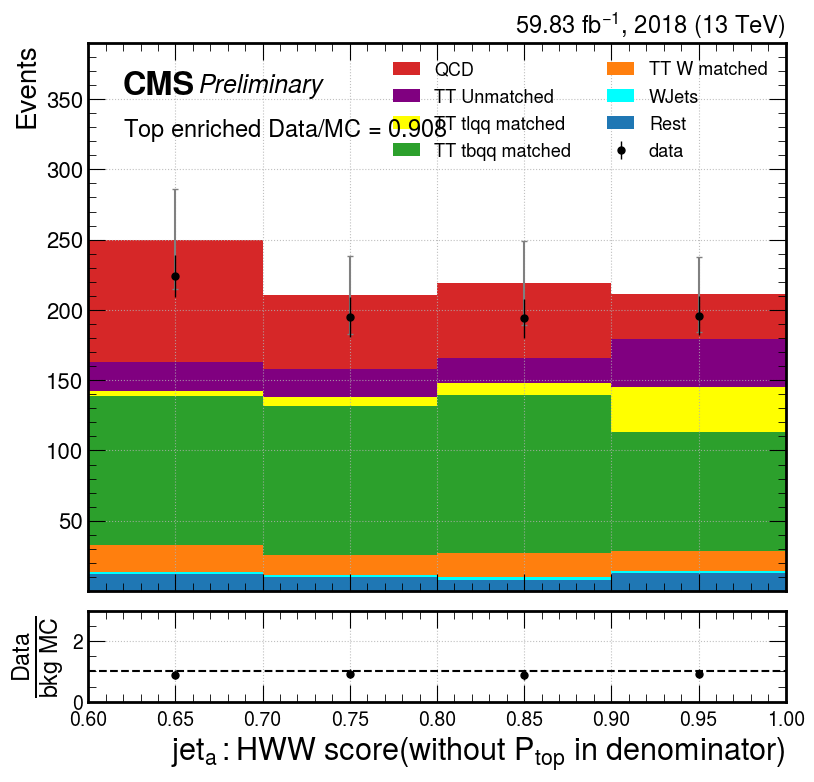

k,v =  ('data', <Array [6.03e-05, 8.26e-05, ... 0.0029, 0.0147] type='5477 * float32'>)
[17. 13. 10. 17.]
k,v =  ('QCD', <Array [0.00438, 0.00317, ... 0.0112, 0.00433] type='4748 * float32'>)
[3.67523473 5.56871096 1.71066907 0.94277887]
k,v =  ('WJets', <Array [0.017, 0.00835, ... 0.0358, 0.0639] type='217 * float32'>)
[0.         0.1201059  0.12102085 0.        ]
k,v =  ('Rest', <Array [0.00935, 0.00232, ... 0.0148, 0.00406] type='5165 * float32'>)
[1.0128551  0.15648537 0.90884153 1.28814077]
k,v =  ('TotalSignal', <Array [0.873, 0.0109, ... 0.0414, 0.00677] type='1343 * float32'>)
[0.01685845 0.03622859 0.03075701 0.06183199]
k,v =  ('ggF', <Array [0.873, 0.0109, ... 0.00245, 0.000245] type='5 * float32'>)
[0.         0.         0.01104439 0.        ]
k,v =  ('VH', <Array [0.00383, 0.0757, ... 0.0414, 0.00677] type='53 * float32'>)
[0.00243877 0.         0.00244958 0.00276932]
k,v =  ('ttH', <Array [0.00337, 0.506, ... 0.837, 0.00926] type='1285 * float32'>)
[0.01441968 0.03622859 

/tmp/ipykernel_91478/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_91478/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_91478/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


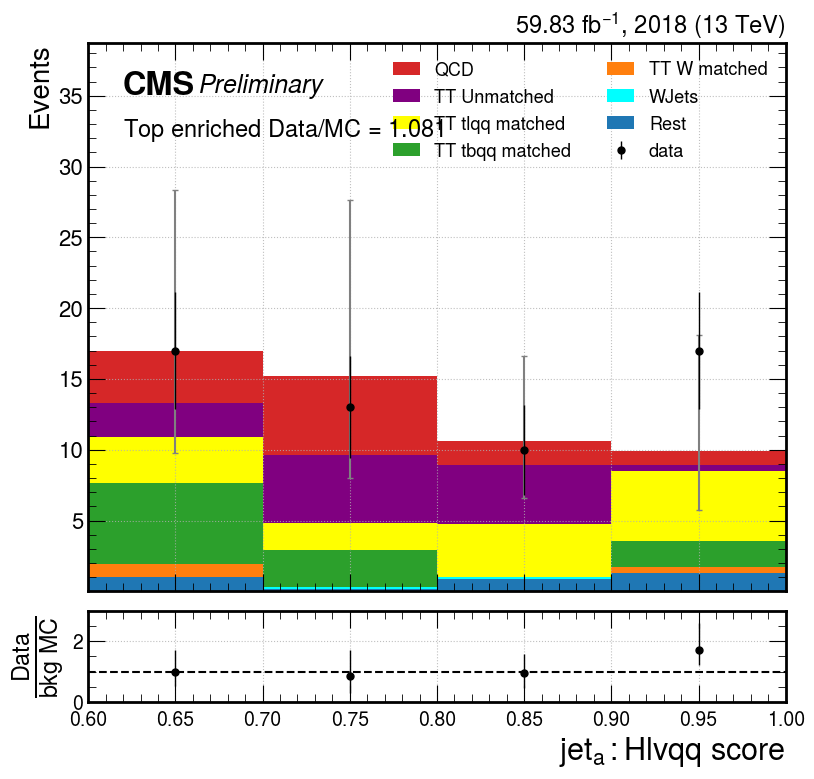

In [45]:
# validate_runPlots(region = "PS_btag", othertext = "PS b_tagged ",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = True)
validate_runPlots(region = "tlqq_SFed", othertext = r"$SF\ applied $",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)
# validate_runPlots(region = "tbqq", othertext = r"$t^{bqq}\ enriched$",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)
validate_runPlots(region = "tbqq", othertext = r"$Top\ enriched$",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)

### Signal contamination test

In [11]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def conta_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2017', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",postfit_files = "",SF = None, sample = None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81,"2016":36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            pass
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT tbqq matched","TT W matched","TT tlqq matched","TT Unmatched","WJets","Rest"]
    for (k,v) in arrays.items():
        print("k,v = ",(k,v))
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        print(h)
        if SF and sample == "tbqq":
            if k == "TT tbqq matched": 
                for i in range(len(h)):
                    h[i] = h[i]*SF[i] 
        if SF and sample == "tlqq":
            if k == "TT tlqq matched": 
                for i in range(len(h)):
                    print("xxx")
                    h[i] = h[i]*SF[i] 
        # here the var are just usual standard variance
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"#FF69B4","VH":"blue","ttH":"#FFD700","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","TT W matched","TT tbqq matched","TT tlqq matched","TT Unmatched","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4","#00ffff", "#ff7f0e", "#2ca02c","#ffff00","#800080","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #test:
        print("total error:",bkg_err)
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        # ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 3) #ratio 0-2
        # ax1.set_ylim(0.5, 1.5)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=14, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/validation/24Jan07/{year}_{plot_name}{suffix}_{region}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [12]:
SFs_tbqq = [1.039,1.041,1.047,1.060,1.074,1.077,1.074,1.067]
SFs_tlqq = [0.842,1.128,0.875,1.003,0.852,1.020,0.911,0.809]

In [18]:
def conta_runPlots(region = "PS", events = files,othertext = "", blind = False, postfit_files = "",log = True,SF = None):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events if k != "ttbar_val"}   
    conta_plot(arrays = {k: events[k][CUT[region][k]]["tagger_wo_top"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='HWWwithoutTop', x_name=r'$jet_{a}:HWW\ score(without\ P_{top}\ in\ denominator)$', x_max=1, x_min=0.6, bins=8, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files,log = log,SF = SFs_tbqq,sample = "tbqq")
    conta_plot(arrays = {k: events[k][CUT[region][k]]["tagger_lvqq_vs_tbqq"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='Hlvqq', x_name=r'$jet_{a}:Hlvqq\ score$', x_max=1, x_min=0.6, bins=8, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files,log = log, SF = SFs_tlqq, sample = "tlqq")
    # conta_plot(arrays = {k: events[k][CUT[region][k]]["DPhi"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='DPhi', x_name=r'$\delta \phi $', x_max=3.2, x_min=0, bins=10, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log, SF = None, sample = "")
    # conta_plot(arrays = {k: events[k][CUT[region][k]]["a_HWW_V2"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='HWW', x_name=r'$jet_{a}:HWW\ score$', x_max=1, x_min=0.5, bins=5, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["MET_et"]/events[k][CUT[region][k]]["PTj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='MET_ptja', x_name=r'$MET/pT_{ja}$', x_max=1, x_min=0, bins=10, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["Mj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='Mja', x_name=r'$jet_{a}:jet\ mass$', x_max=240, x_min=40, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["MET_et"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='MET', x_name=r'$MET$', x_max=300, x_min=0, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["PTj_V2_a"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='PTja', x_name=r'$jet_{a}:pT$', x_max=1200, x_min=200, bins=20, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)
    # validate_plot(arrays = {k: events[k][CUT[region][k]]["nb_t_deep_in"] for k in events if k != "ttbar_val"},  region = region, othertext = othertext, plot_name='nbt_in', x_name=r'$N(b\ jets,tight\ WP,inclusive)$', x_max=5, x_min=0, bins=5, weight =weight, year="2018",blind = blind, blindMC = False,postfit_files = postfit_files,log = log)

In [14]:
CUT = {  
        # "PS_btag"   : {k:  (files[k]["nb_t_deep_in"] >= 1) for k in files if k != "ttbar_val"},      
        "tlqq_SFed" : {k: (files[k]["DPhi"] <= 0.6) & (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 400) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        "tbqq_SFed" : {k: (files[k]["DPhi"] >= 2) & (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 400) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        "tlqq" : {k: (files[k]["DPhi"] <= 0.6) & (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 400) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        "tbqq" : {k: (files[k]["DPhi"] >= 2.0) & (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 125) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 400) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
        # "tbqq_noHiggsMass" : {k:  (files[k]["nb_t_deep_in"] >= 1) & (files[k]["Mj_V2_a"] >= 160) & (files[k]["Mj_V2_a"] <= 225) & (files[k]["PTj_V2_a"] > 500) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.4) for k in files if k != "ttbar_val"},
    }

In [15]:
# for tbqq:
0.95 - 1:  SF is 1.005 +/-0.167(stat) +/-0.045(pt) +0.001/-0.003(sys) +/-0.238(match) 
0.9 - 0.95:SF is 1.415 +/-0.282(stat) +/-0.029(pt) +0.004/-0.003(sys) +/-0.335(match)
0.85 - 0.9:SF is 1.078 +/-0.156(stat) +/-0.012(pt) +0.003/-0.002(sys) +/-0.255(match) 
0.8 - 0.85:SF is 0.959 +/-0.108(stat) +/-0.040(pt) +0.000/-0.001(sys) +/-0.227(match) 
0.75 - 0.8:SF is 1.121 +/-0.132(stat) +/-0.011(pt) +0.006/-0.006(sys) +/-0.265(match)
0.7 - 0.75:SF is 1.016 +/-0.118(stat) +/-0.013(pt) +0.001/-0.001(sys) +/-0.240(match) 
0.65 - 0.7:SF is 1.305 +/-0.161(stat) +/-0.035(pt) +0.007/-0.008(sys) +/-0.308(match)
0.6 - 0.65:SF is 1.127 +/-0.139(stat) +/-0.019(pt) +0.003/-0.000(sys) +/-0.266(match)
# for tlqq:


SyntaxError: invalid syntax (2967481461.py, line 2)

k,v =  ('data', <Array [0.194, 0.0277, ... 0.813, 0.056] type='6553 * float32'>)
[151. 124. 121.  84. 100. 112. 125. 238.]
k,v =  ('QCD', <Array [0.94, 0.00194, 0.791, ... 0.2, 0.0244] type='8971 * float32'>)


[80.31378405 67.96356156 61.63752452 59.80976768 49.01517768 38.06660307
 45.11656834 16.75262436]
k,v =  ('WJets', <Array [0.754, 0.0058, ... 0.00807, 0.0251] type='6117 * float32'>)
[ 2.64863291  2.5755768   2.35972561  1.74081462  3.05965743  3.18005389
  4.11924137 10.3233942 ]
k,v =  ('Rest', <Array [0.0153, 0.0799, ... 0.628, 0.815] type='3649 * float32'>)
[ 3.64370377  7.24654407  5.30198157  4.86560732  3.87512932  7.30090835
  7.56605323 21.59529031]
k,v =  ('TotalSignal', <Array [0.965, 0.52, 0.377, ... 0.0408, 0.579] type='1493 * float32'>)
[0.05917762 0.06887146 0.08642032 0.1017039  0.09310271 0.14351734
 0.22732001 0.66252449]
k,v =  ('ggF', <Array [0.747, 0.88, 0.988, 0.0172] type='4 * float32'>)
[0.         0.         0.00477293 0.         0.         0.00895096
 0.         0.00976998]
k,v =  ('VH', <Array [0.482, 0.984, 0.971, ... 0.0408, 0.579] type='81 * float32'>)
[0.00230727 0.00129143 0.00087019 0.00124618 0.0047258  0.00333026
 0.00955458 0.03355581]
k,v =  ('ttH'

/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/home/pku/zhaoyz/anaconda3/envs/HWW/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/pku/zhaoyz/anaconda3/envs/HWW/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encounter

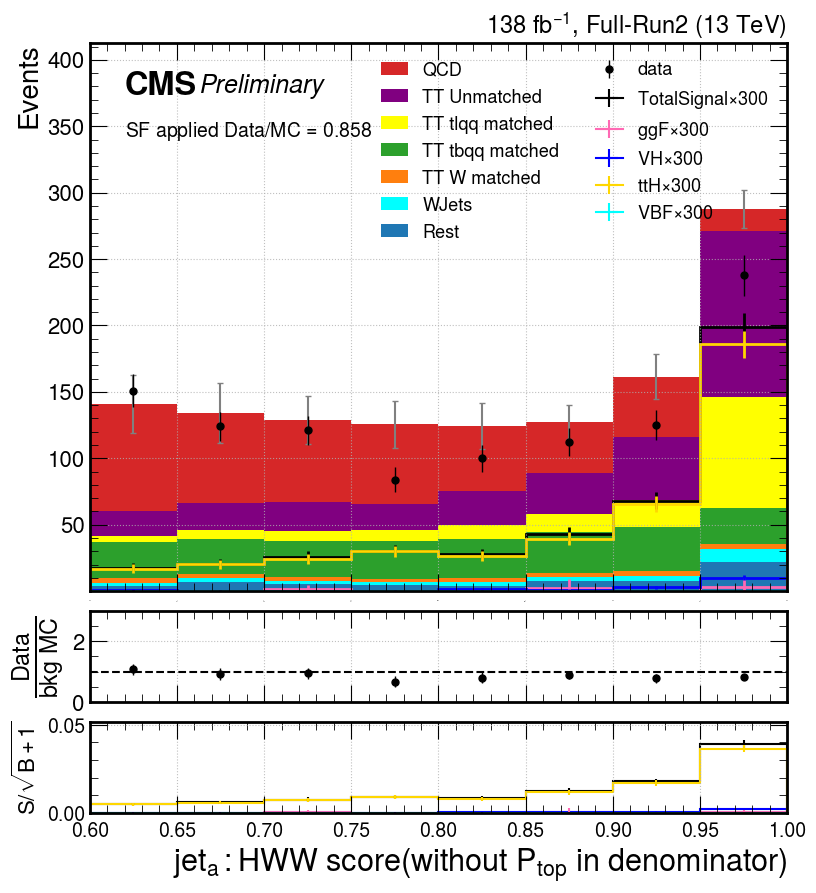

k,v =  ('data', <Array [0.0384, 0.000532, ... 0.00677, 0.00951] type='6553 * float32'>)
[17. 15. 15. 18. 17. 18. 18. 24.]
k,v =  ('QCD', <Array [0.000614, 0.000424, ... 0.143, 0.00433] type='8971 * float32'>)
[9.51304253 3.29539972 9.4507996  0.7673301  1.16693955 0.14870657
 0.85949365 0.        ]
k,v =  ('WJets', <Array [0.0524, 0.00128, ... 0.000768, 0.0166] type='6117 * float32'>)
[1.17424146 1.04635546 1.04814849 1.05610528 1.50387687 1.43889281
 2.07105705 2.4559681 ]
k,v =  ('Rest', <Array [0.0115, 0.00749, ... 0.0214, 0.2] type='3649 * float32'>)
[0.77463091 1.31332705 1.44910191 0.50671111 1.24242739 1.828847
 2.80151886 3.85518834]
k,v =  ('TotalSignal', <Array [0.447, 0.28, ... 0.00139, 0.00919] type='1493 * float32'>)
[0.02440358 0.04959073 0.02484644 0.03450807 0.03957354 0.06218248
 0.07602102 0.12093574]
k,v =  ('ggF', <Array [0.669, 0.0541, 0.665, 0.017] type='4 * float32'>)
[0.         0.01454291 0.         0.         0.         0.
 0.         0.        ]
k,v =  ('VH',

/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered i

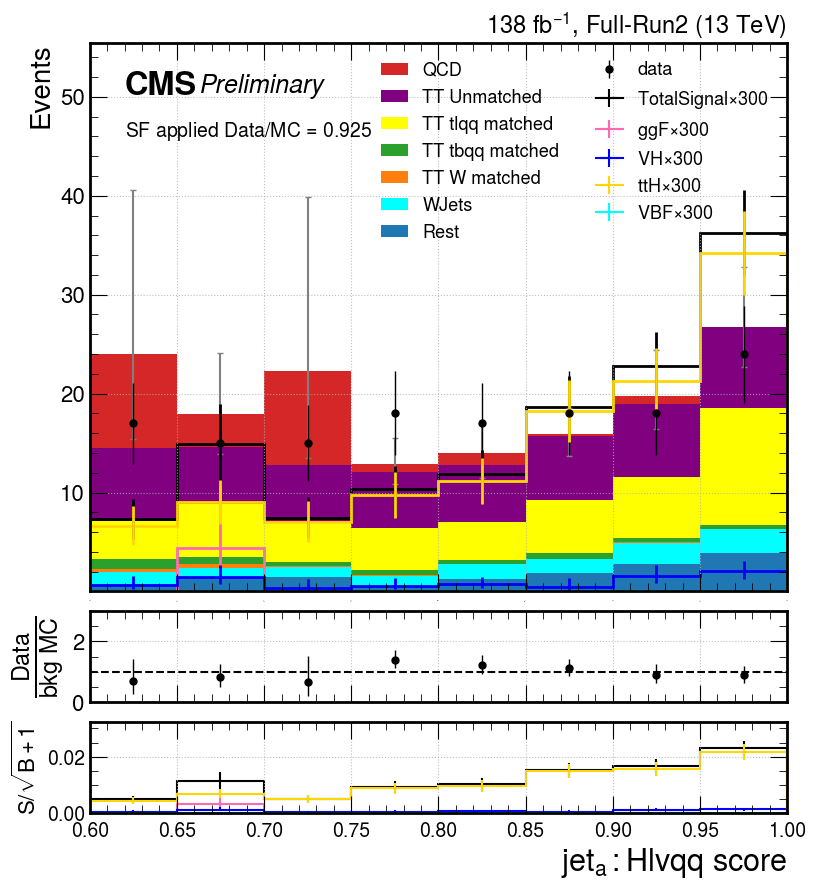

k,v =  ('data', <Array [0.218, 0.031, 0.447, ... 0.122, 0.0331] type='19999 * float32'>)
[431. 432. 378. 375. 356. 326. 282. 248.]
k,v =  ('QCD', <Array [0.125, 0.012, 0.42, ... 0.0583, 0.702] type='9689 * float32'>)
[139.10280416 138.18281322 132.94422882  77.02377316  98.15996752
  94.98417105  89.02601694  40.2298989 ]
k,v =  ('WJets', <Array [0.0671, 0.0346, ... 0.0555, 0.0668] type='7489 * float32'>)
[4.56831188 5.30417797 5.33978555 4.56133969 6.44972794 4.91066326
 5.08199742 3.62500429]
k,v =  ('Rest', <Array [0.0672, 0.0451, ... 0.182, 0.688] type='18532 * float32'>)
[21.0424222  16.53745014 17.61144674 13.89087286 12.74381321 13.49226827
 17.03485923 14.47809404]
k,v =  ('TotalSignal', <Array [0.183, 0.957, 0.68, ... 0.994, 0.0423] type='4405 * float32'>)
[0.2344614  0.2177057  0.23670576 0.23240535 0.32278046 0.35366807
 0.4848645  0.855649  ]
k,v =  ('ggF', <Array [0.183, 0.0482, 0.92, ... 0.0301, 0.164] type='10 * float32'>)
[0.         0.         0.         0.         0. 

/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/home/pku/zhaoyz/anaconda3/envs/HWW/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/pku/zhaoyz/anaconda3/envs/HWW/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encounter

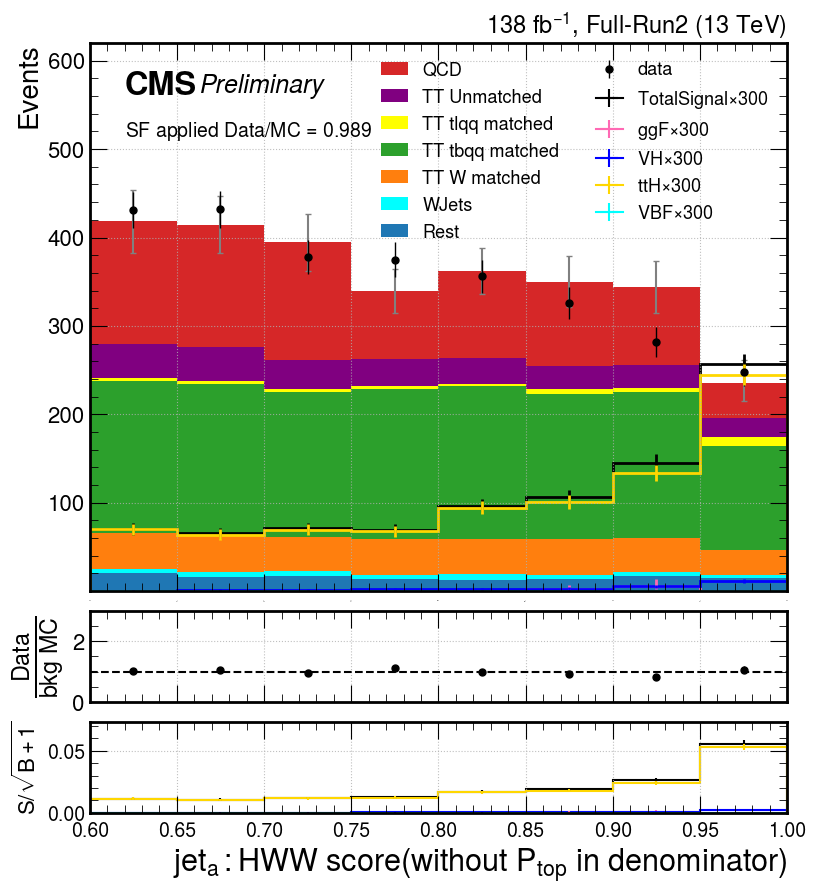

k,v =  ('data', <Array [0.0203, 0.012, ... 0.0147, 0.00342] type='19999 * float32'>)
[19. 18. 14. 21. 11. 15. 16. 13.]
k,v =  ('QCD', <Array [0.00896, 0.00211, ... 0.011, 0.00846] type='9689 * float32'>)
[ 2.99916688  4.41897693  5.64248969 20.22132588  1.21161921  0.45760702
  2.77206701  3.7636216 ]
k,v =  ('WJets', <Array [0.0204, 0.00955, ... 0.00357, 0.0639] type='7489 * float32'>)
[0.16707881 0.14031579 0.57643917 0.43501346 0.42319473 0.33451759
 0.22652186 0.29971025]
k,v =  ('Rest', <Array [0.00285, 0.0191, ... 0.00771, 0.00406] type='18532 * float32'>)
[2.0555675  1.03123369 0.96088164 0.85584358 0.94453334 0.57034024
 0.7765639  0.65540605]
k,v =  ('TotalSignal', <Array [0.0111, 0.0572, ... 0.0414, 0.00677] type='4405 * float32'>)
[0.02515969 0.02666221 0.03414492 0.02727313 0.0355915  0.035827
 0.04757355 0.09069355]
k,v =  ('ggF', <Array [0.0111, 0.0163, ... 0.000855, 0.00245] type='10 * float32'>)
[0.         0.         0.         0.         0.         0.01104439
 0.     

/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_41462/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_41462/2123724067.py:52: RuntimeWarning: invalid value encountered i

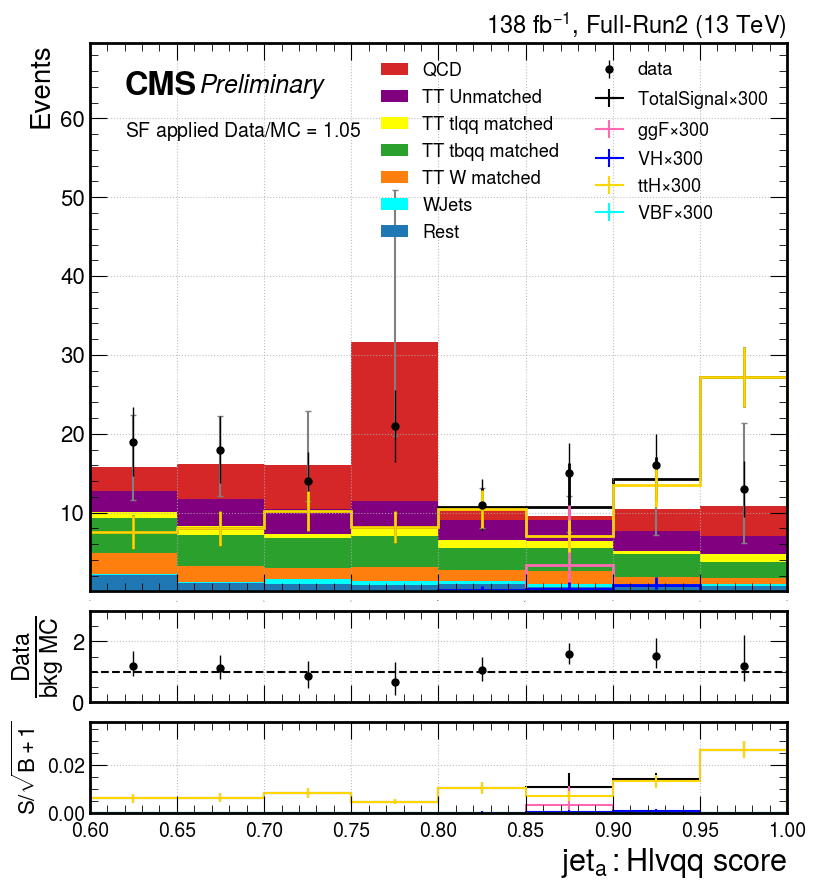

In [19]:
# conta_runPlots(region = "PS_btag", othertext = "PS b_tagged ",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = True)
conta_runPlots(region = "tlqq_SFed", othertext = r"$SF\ applied $",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)
conta_runPlots(region = "tbqq_SFed", othertext = r"$SF\ applied $",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)
# conta_runPlots(region = "tbqq", othertext = r"$t^{bqq}\ enriched$",log = False)
# conta_runPlots(region = "tlqq", othertext = r"$t^{lqq}\ enriched$",log = False)
# conta_runPlots(region = "tbqq", othertext = r"$Top\ enriched$",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",log = False)

### some other test

In [25]:
np.sqrt((0.224)**2 + (0.031**2) + (0.024)**2 + 0.461**2)

0.5140369636514479

In [26]:
np.sqrt((0.117)**2 + (0.015**2) + (0.004)**2 + 0.253**2)

0.27917557199726484